[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alessandronascimento/LabData/blob/main/DSF_scripts/DSF_fit.ipynb)

# DSF Analysis #

This colab was written for a rapid and simple analysis of DSF data following the general principles decribed in [Samuel et al., 2021](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-021-00577-1):

```
Samuel et al. Journal of Cheminformatics (2021) 13:99
https://doi.org/10.1186/s13321-021-00577-1
```

Basically, we want to fit the DSF curve to a model like:

$ f(x) = c + \frac{d-c}{\left[1 + exp(b(ln(x) - ln(e)))\right]^f} $

Here:


*   $b$ = slope
*   $c$ = minimum fluorescence value
*   $d$ = maximum fluorescence value
*   $e$ = inflection point
*   $f$ = asymmetry factor, i.e. the difference in
the rates of approach from the inflection point to the
lower and the upper asymptotes.

The effect of these parameter was shown by the authors in the Figure 5 of their paper:



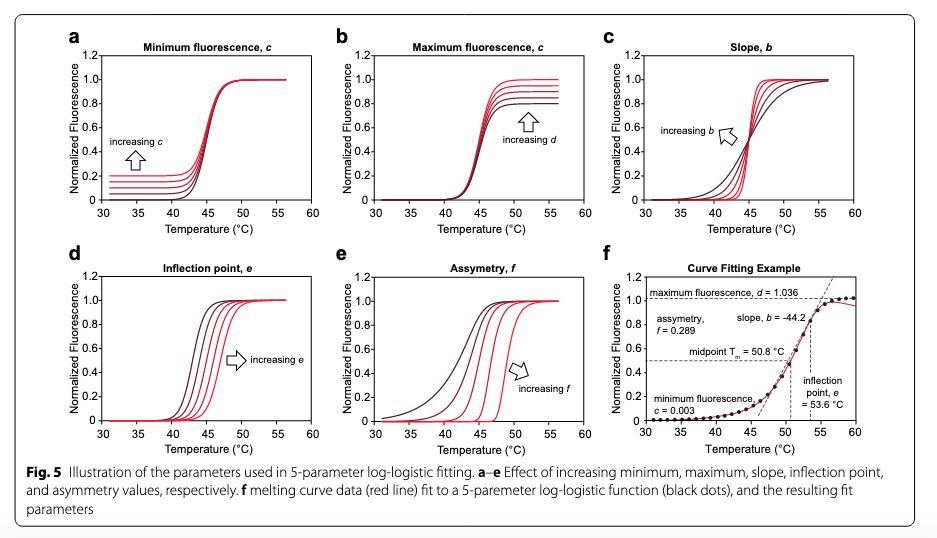

## Our implementation of the Model ##

In our implementation, the raw fluorescence data is normalized in the beginning of the analysis. So, the parameters $c$ and $d$ will be $0.0$ and $1.0$ by default, and the numerator of the equation above will be also $1.0$.

Secondly, we remove the fluorescence reduction after the unfolding transition, to make the curve more sigmoidal. By doing this, a plateau is formed in the maximum of the fluorescence in the end of the run.

The model that is actually used to fit the data is:

$ f(x) = c + \frac{1.0}{\left[1 + exp(b(ln(x) - ln(e)))\right]^f} $

So that our model depend only on four parameter: $c$, $b$, $e$ and $f$.

Finally, the $T_M$ is computed as:

$T_M = \frac{e}{exp\left[ - \frac{1}{b} \ln \left( 2^\frac{1}{f} -1\right) \right]} $

The reason for this transformation is (as stated by the authors):

```
The inflection point of an asymmetric sigmoidal curve does not coincide with its midpoint. 
The midpoint Tm is calculated using the fit parameters according to the equation (above)
```

Finally, the normalized data is graphed with the fitted model and the computed $T_M$, shown as a vertical line.

This calculation is done for every column in the spreadsheet.

## Instructions to Use this Colab ##

In order to use this colab, make sure you:



1.   Have your raw fluorescence data in an Excel Spreadsheet. This first column must be named 'Temperature'. 
2.   Go in **Execution Environment** and click on **Run All**.
3.   A button will be displayed below allowing you to upload your file. 
4.   That's it. 

Please, let me know if you have problems with this Colab.



In [123]:
#@title Preparing the environment....
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.stats
import math

from google.colab import files
import pandas as pd

def normalize(my_y):
  my_norm_y=[]
  diff = max(my_y)-min(my_y)
  for i in my_y:
    temp = (i-min(my_y))/diff
    my_norm_y.append(temp)
  return my_norm_y

def normalize2(my_y):
  my_norm_y=[]
  diff = max(my_y)-min(my_y)
  found_max=False;
  for i in my_y:
    if (i == max(my_y)):
      found_max=True;
    if (not found_max):
      temp = (i-min(my_y))/diff
      my_norm_y.append(temp)
    else:
      my_norm_y.append(1.0);
  return my_norm_y  

def fitting_function(p0, my_x, my_y):
  err = 0.0;
  sq_err = 0.0;
  for i in range(0, len(my_x)):
#    Y = ((p0[5]*my_x[i])+p0[1]) * ( (p0[2]-p0[1]) / (math.pow((1.0 + math.exp(p0[0]*(math.log(my_x[i])-math.log(p0[3])))),p0[4])))
    Y = (p0[0]) + ( (1.0) / (math.pow((1.0 + math.exp(p0[1]*(math.log(my_x[i])-math.log(p0[2])))), p0[3])))
    err = (Y - my_y[i])
    sq_err += (err * err);
  return sq_err

def bai_fitting_function(p0, my_x, my_y):
  temp = my_x+273.15;
  R = 1.987/1000;
  sq_err = 0.0;
  # We are assuming dH=1.0 and Cp =1.0 here
  for i in range(0, len(my_x)):
    dG = (1.0 - (temp[i]/(p0[4]+273.15))) - (p0[4]+273.15-temp[i]+(temp[i]*np.log(temp[i]/(p0[4]+273.15))));
    Ku = np.exp(-dG/(R*temp[i]))
    Y = (Ku/(1+Ku))*(p0[0]*temp[i] + p0[1]) + (1/(1+Ku))*(p0[2]*temp[i] + p0[3])
    err = (Y - my_y[i])
    sq_err += (err * err);
  return sq_err  

def generate_fitted_data(p0, my_x):
  my_fitted_y = [];
  for i in range(0, len(my_x)):
#    Y = ((p0[5]*my_x[i])+p0[1]) * ( (p0[2]-p0[1]) / (math.pow((1.0 + math.exp(p0[0]*(math.log(my_x[i])-math.log(p0[3])) )),p0[4])))
    Y = (p0[0]) + ( (1.0) / (math.pow((1.0 + math.exp(p0[1]*(math.log(my_x[i])-math.log(p0[2])))), p0[3])))
    my_fitted_y.append(Y);
  return(my_fitted_y)

def generate_fitted_data_bai(p0, my_x):
  my_fitted_y = [];
  R = 1.987/1000;
  temp = my_x+273.15;
  for i in range(0, len(my_x)):
    dG = (1.0 - (temp[i]/(p0[4]+273.15))) - (p0[4]+273.15-temp[i]+(temp[i]*np.log(temp[i]/(p0[4]+273.15))));
    Ku = np.exp(-dG/(R*temp[i]))
    Y = (Ku/(1+Ku))*(p0[0]*temp[i] + p0[1]) + (1/(1+Ku))*(p0[2]*temp[i] + p0[3])
    my_fitted_y.append(Y);
  return(my_fitted_y)  
  

In [ ]:
#@title Upload of the raw data (Excel file)
uploaded = files.upload()
fluo_datafile = ""

for fn in uploaded.keys():
  print('User uploaded file "{name}" uploaded. File has {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  fluo_datafile=fn

In [ ]:
#@title Data Analysis
#print("User file: %s" % fluo_datafile);

df = pd.read_excel(fluo_datafile)

my_x = df['Temperature']
num_datasets = 96;
subplot_horiz = math.ceil(math.sqrt(num_datasets))
subplot_vert = math.ceil(num_datasets / subplot_horiz)
#plt.figure(5, figsize=(18,11))


for sample in df:
  if (sample != 'Temperature'):
    my_sample = sample;
    my_unorm_y = df[sample]
    my_y = normalize2(my_unorm_y)
    p0 = np.zeros(4);
    p0[0] = 0.0;         # minimum in fluorescence (c in Samuel, 2021)
    p0[1] = 1.0;         # slope (b in Samuel, 2021)
    p0[2] = 40.0;        # inflection point (e)
    p0[3] = 1.0;         # asymmetry factor (f, difference in the rates of approach from the inflection point to the lower and the upper asymptotes)
    
    fit = scipy.optimize.minimize(fitting_function, p0, args=(my_x, my_y), method= 'Nelder-Mead')
    fitted_data=generate_fitted_data(fit.x, my_x);

    print("Parameters for sample %s (c,b,e,f, as in Samuel, 2021):" % my_sample);
    print(fit.x)
    Tm = fit.x[2] / math.exp(-(1.0/fit.x[1])* math.log(math.pow(2, 1/fit.x[3]) - 1.0))
    print("%-6s Tm = %2d .oC" % (my_sample, int(Tm)));
    
    plt.axvline(Tm, 0, 1, label='Melting Temperature')
    plt.plot(my_x, my_y, 'bs', my_x, fitted_data, 'r')
    plt.title("DSF Fitting for %s" % my_sample);
    plt.xlabel("Temperature (.oC)")
    plt.ylabel("Normalized Fluorescence (a.u)")

    plt.show()  